In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# URL Download
import csv
import io
import urllib.request
import requests

2022-03-06 16:14:13.887523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 16:14:13.887571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Read in data

In [2]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [3]:
df_feat = pd.read_csv("../raw_data/daily_features_theft.csv")

In [4]:
df_feat.columns

Index(['Unnamed: 0', 'date', 'min_temp', 'max_temp', 'the_temp',
       'weather_state_name', 'weather_state_abbr', 'wind_speed',
       'wind_direction', 'air_pressure', 'humidity', 'visibility',
       'daylight_hours', 'isholidays', 'weekday', 'weeknum'],
      dtype='object')

In [5]:
df_feat.drop(columns = 'Unnamed: 0', inplace=True )

In [6]:
df_feat.head()

,date,min_temp,max_temp,the_temp,weather_state_name,weather_state_abbr,wind_speed,wind_direction,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum
0,2021-01-01,0.005,2.395,2.070,Sleet,sl,3.020726,227.616640,1007.0,93,6.031650,07:50:24,1,4,53
1,2021-01-02,-1.135,3.045,2.465,Heavy Cloud,hc,2.666541,193.699868,1015.0,89,12.863316,07:51:41,0,5,53
2,2021-01-03,-1.315,1.955,0.985,Snow,sn,9.161659,55.677273,1015.0,96,2.144352,07:53:05,0,6,53
3,2021-01-04,0.030,1.780,1.355,Sleet,sl,6.271227,54.331796,1017.0,96,2.927901,07:54:33,0,0,1
4,2021-01-05,-0.030,2.730,1.270,Light Rain,lr,6.009528,26.500356,1017.0,94,7.021805,07:56:08,0,1,1


In [7]:
df_theft = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

In [8]:
df_theft.head()

,Unnamed: 0,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,datetime_theft_mean,BZR,PGR,Bezirk
0,0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,7100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0,2022-02-26 14:00:00,71001,710,7
1,1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,2100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0,2022-02-28 16:00:00,21001,210,2
2,2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,8300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0,2022-02-28 20:00:00,83009,830,8
3,3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,4400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0,2022-02-28 08:00:00,44007,440,4
4,4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,9100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0,2022-02-25 11:00:00,91003,910,9


# Combine datasets

## Group theft data by Bezirk and date

In [9]:
# Group dataframe by date and LOR
df_theft = df_theft.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft.fillna(value = 0, inplace=True)

In [10]:
# create "total" column which sums up data for each day
df_theft["total"] = df_theft.sum(axis=1)


df_theft.shape

(424, 13)

In [11]:
df_feat.columns

Index(['date', 'min_temp', 'max_temp', 'the_temp', 'weather_state_name',
       'weather_state_abbr', 'wind_speed', 'wind_direction', 'air_pressure',
       'humidity', 'visibility', 'daylight_hours', 'isholidays', 'weekday',
       'weeknum'],
      dtype='object')

In [12]:
df_theft.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'total'], dtype='object', name='Bezirk')

## Merge datasets

We merge the "total" column from the theft dataset with the features from the features dataset

In [13]:
# First we have to reset the index in the df_theft to create a column to merge on 

df_theft.reset_index( inplace=True)

In [14]:
# as the last step we rename the date column to match the name in df_feat
df_theft = df_theft.rename(columns={"date_theft_start": "date"})

In [15]:
df_feat.columns

Index(['date', 'min_temp', 'max_temp', 'the_temp', 'weather_state_name',
       'weather_state_abbr', 'wind_speed', 'wind_direction', 'air_pressure',
       'humidity', 'visibility', 'daylight_hours', 'isholidays', 'weekday',
       'weeknum'],
      dtype='object')

In [16]:
df_theft.columns

Index(['date', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'total'], dtype='object', name='Bezirk')

In [17]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [18]:
df_theft[["date", "total"]].to_csv("../bike_theft_total_daily.csv")

In [19]:
# combine the datasets
df_combined = pd.merge(df_feat, df_theft, on = "date")

In [20]:
df_combined.head()

,date,min_temp,max_temp,the_temp,weather_state_name,weather_state_abbr,wind_speed,wind_direction,air_pressure,humidity,...,4,5,6,7,8,9,10,11,12,total
0,2021-01-01,0.005,2.395,2.070,Sleet,sl,3.020726,227.616640,1007.0,93,...,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,16.0
1,2021-01-02,-1.135,3.045,2.465,Heavy Cloud,hc,2.666541,193.699868,1015.0,89,...,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,16.0
2,2021-01-03,-1.315,1.955,0.985,Snow,sn,9.161659,55.677273,1015.0,96,...,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,17.0
3,2021-01-04,0.030,1.780,1.355,Sleet,sl,6.271227,54.331796,1017.0,96,...,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0,33.0
4,2021-01-05,-0.030,2.730,1.270,Light Rain,lr,6.009528,26.500356,1017.0,94,...,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0,29.0


## Select relevant features

In [21]:
df_combined.columns

Index([              'date',           'min_temp',           'max_temp',
                 'the_temp', 'weather_state_name', 'weather_state_abbr',
               'wind_speed',     'wind_direction',       'air_pressure',
                 'humidity',         'visibility',     'daylight_hours',
               'isholidays',            'weekday',            'weeknum',
                          1,                    2,                    3,
                          4,                    5,                    6,
                          7,                    8,                    9,
                         10,                   11,                   12,
                    'total'],
      dtype='object')

- For now we will drop the Bezirke columns, and the weather_state_name as well as weather_state_abbr
- We will also drop min_temp and max_temp and just keep the_temp 
- We will further drop wind_direction

In [22]:
cols_select = ["date", "the_temp", "wind_speed", "air_pressure", "humidity", "visibility", 
              "daylight_hours", "isholidays", "weekday", "weeknum", 
              "total"]

In [23]:
df_combined = df_combined[cols_select]

In [24]:
df_combined.head()

,date,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total
0,2021-01-01,2.070,3.020726,1007.0,93,6.031650,07:50:24,1,4,53,16.0
1,2021-01-02,2.465,2.666541,1015.0,89,12.863316,07:51:41,0,5,53,16.0
2,2021-01-03,0.985,9.161659,1015.0,96,2.144352,07:53:05,0,6,53,17.0
3,2021-01-04,1.355,6.271227,1017.0,96,2.927901,07:54:33,0,0,1,33.0
4,2021-01-05,1.270,6.009528,1017.0,94,7.021805,07:56:08,0,1,1,29.0


In [25]:
df_combined = df_combined.set_index("date")

In [26]:
# Change dtype of daylight_hours from object to float
# first calculate seconds
df_combined["daylight_hours"] = df_combined["daylight_hours"].apply(lambda x: sum(int(x) * 60 ** i for i, x in enumerate(reversed(x.split(':')))))

In [27]:
# then calculate hours as float from the seconds
df_combined["daylight_hours"] = df_combined["daylight_hours"]/3600

In [28]:
df_combined.dtypes

the_temp          float64
wind_speed        float64
air_pressure      float64
humidity            int64
visibility        float64
daylight_hours    float64
isholidays          int64
weekday             int64
weeknum             int64
total             float64
dtype: object

# Train-test-split

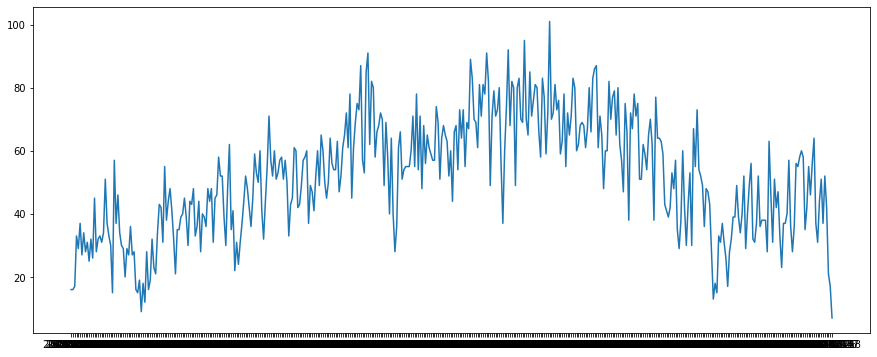

In [29]:
plt.figure(figsize = (15, 6))
plt.plot(df_combined["total"]);

In [30]:
df_combined["total"].mean()

51.62971698113208

In [31]:
df_combined["total"].std()

18.194955888318802

In [32]:
int(len(df_combined) * 0.8)

339

In [33]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset["total"][i + window_size : i + window_size  + future_horizon, ])

  return np.array(X), np.array(y)

In [34]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_combined.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_combined.iloc[339:, :])

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 10), (307, 1), (53, 31, 10), (53, 1))

In [36]:
X_train[0][0]

array([2.07000000e+00, 3.02072617e+00, 1.00700000e+03, 9.30000000e+01,
       6.03165016e+00, 7.84000000e+00, 1.00000000e+00, 4.00000000e+00,
       5.30000000e+01, 1.60000000e+01])

# KFold Cross validation

In [37]:
def model_cross_validation(model):
    model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")
    
    es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    results = []
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X_train)

    for train_index, test_index in kf.split(X_train):

        # split the data into train and test set
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]

        model = model 
        
        # Fit the model
        model.fit(X_train_cv, 
                  y_train_cv, 
                  batch_size = 16, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)
        
        # Evaluate the model on the test data
        results.append(model.evaluate(X_test_cv, y_test_cv))
        
    return results

# Modelling

## One-dense-layer model

In [42]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])
base_model_cv_results = model_cross_validation(base_model)

2022-03-04 18:21:47.183246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-04 18:21:47.183354: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-04 18:21:47.183381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-C0GM00LC): /proc/driver/nvidia/version does not exist
2022-03-04 18:21:47.184357: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 2ms/step - loss: 263.9324 - mean_absolute_percentage_error: 24.4945


In [43]:
np.mean(base_model_cv_results, axis = 0)

array([248.12004395,  24.85413361])

In [40]:
es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

In [48]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])

base_model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")


base_model.fit(X_train, 
                  y_train, 
                  batch_size = 16, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [49]:
base_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 262.6593 - mean_absolute_percentage_error: 36.7870


[262.6593017578125, 36.786991119384766]

## Finetuned model

In [38]:
def create_opt_model(): 
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
    model.add(Dropout(0.2))
    # second LSTM layer
    model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))
    return model

In [58]:
opt_model_cv_results = model_cross_validation(create_opt_model())

2/2 [==============================] - 0s 10ms/step - loss: 172.2122 - mean_absolute_percentage_error: 17.8839


In [59]:
np.mean(opt_model_cv_results, axis = 0)

array([321.25039673,  36.76093025])

In [41]:
opt_model = create_opt_model()
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [42]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 272.8918 - mean_absolute_percentage_error: 42.0894


[272.8917541503906, 42.089439392089844]

# Rolling average

## Calculate rolling average

In [43]:
window_size = 3
# Moving average without center option: 
    #calculate fill value for the beginning of the time series
    #fill_value = df_combined["total"][window_size:window_size*2].mean()
# moving average with center option: 
# calculate fill value: mean of the last seven observations: 
fill_value = df_combined["total"][-window_size].mean()
fill_value

21.0

In [44]:
df_combined["total_moving_average"] = df_combined["total"].rolling(window=window_size, center = True).mean().fillna(fill_value)

In [46]:
df_combined.head()

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total,total_moving_average
date,,,,,,,,,,,
2021-01-01,2.070,3.020726,1007.0,93,6.031650,7.840000,1,4,53,16.0,21.000000
2021-01-02,2.465,2.666541,1015.0,89,12.863316,7.861389,0,5,53,16.0,16.333333
2021-01-03,0.985,9.161659,1015.0,96,2.144352,7.884722,0,6,53,17.0,22.000000
2021-01-04,1.355,6.271227,1017.0,96,2.927901,7.909167,0,0,1,33.0,26.333333
2021-01-05,1.270,6.009528,1017.0,94,7.021805,7.935556,0,1,1,29.0,33.000000


## Feed into model

In [133]:
# For now we only take the total and total_moving_average into account
df_ma = df_combined[["total", "total_moving_average"]]

In [49]:
df_ma = df_combined.drop(columns = ["the_temp", "wind_speed", "air_pressure", "humidity", "visibility", "daylight_hours", 
                                   "isholidays", "weekday", "weeknum"])

In [52]:
df_ma.dtypes

total                   float64
total_moving_average    float64
dtype: object

In [53]:
# Train-test-split
int(len(df_ma)* 0.8)

339

In [54]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_ma.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_ma.iloc[339:, :])

In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 2), (307, 1), (53, 31, 2), (53, 1))

In [138]:
opt_model_cv_results = model_cross_validation(create_opt_model())

2/2 [==============================] - 0s 9ms/step - loss: 166.6505 - mean_absolute_percentage_error: 17.6848


In [139]:
np.mean(opt_model_cv_results, axis = 0)[1]

27.525563430786132

In [56]:
X_train.shape

(307, 31, 2)

In [57]:
opt_model = create_opt_model()
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [58]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 10.4298 - mean_absolute_percentage_error: 7.3513


[10.42979621887207, 7.351312160491943]

In [59]:
# Moving average window size = 7
# Result for not-centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 24.9789
#  filled NAs with mean of days 7-14
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 17.9939
#  filled NAs with mean of last seven observations of whole dataset

# Moving average window size = 5
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 9.5739
# filled NAs with mean of last five observations

# Moving average window size = 3
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 4.4171
# filled NAs with mean of last three observations

# Moving average window size = 1
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 26.0934
# filled NAs with mean of last observation

In [60]:
df_combined.tail()

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total,total_moving_average
date,,,,,,,,,,,
2022-02-24,9.210,9.855780,1011.5,67,14.118175,10.592222,0,3,8,52.0,43.666667
2022-02-25,6.305,11.460817,1016.0,64,10.139846,10.659444,0,4,8,42.0,38.333333
2022-02-26,5.950,6.208894,1032.0,77,11.720303,10.726389,0,5,8,21.0,26.666667
2022-02-27,6.175,3.942383,1037.5,72,12.481172,10.793889,0,6,8,17.0,15.000000
2022-02-28,4.985,5.008762,1036.0,57,14.556242,10.861389,0,0,9,7.0,21.000000


In [61]:
df_ma.tail()

,total,total_moving_average
date,,
2022-02-24,52.0,43.666667
2022-02-25,42.0,38.333333
2022-02-26,21.0,26.666667
2022-02-27,17.0,15.000000
2022-02-28,7.0,21.000000


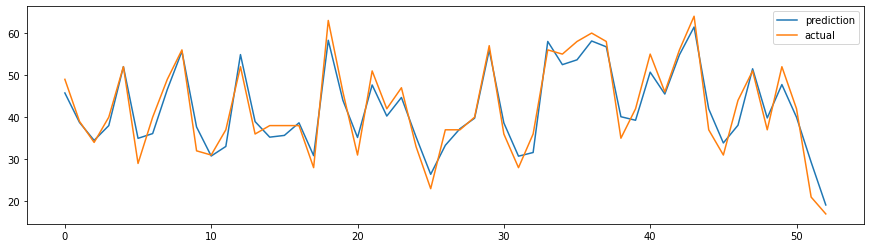

In [62]:
plt.figure(figsize= (15, 4))
plt.plot(opt_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();

# Predict on new data

In [80]:
pred_array = np.array(df_combined[[ "total", "total_moving_average"]][-31:])

In [81]:
pred_array.shape

(31, 2)

In [82]:
pred_array = np.expand_dims(pred_array, 0)

In [83]:
pred_array.shape

(1, 31, 2)

In [84]:
opt_model.predict(pred_array)

array([[30.660246]], dtype=float32)

## Read in most recent dataset

In [85]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df_new = pd.DataFrame(my_list)

In [86]:
df_new.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,03.03.2022,02.03.2022,18,02.03.2022,18,04300621,50,Nein,Herrenfahrrad,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
1,03.03.2022,03.03.2022,16,03.03.2022,16,08100314,0,Nein,Mountainbike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
2,03.03.2022,03.03.2022,02,03.03.2022,02,09200613,0,Nein,Damenfahrrad,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
3,03.03.2022,25.02.2022,08,25.02.2022,17,06300633,950,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,03.03.2022,01.03.2022,06,03.03.2022,16,08100208,710,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [87]:
eng_col_names = [
    "date_reported",
    "date_theft_start",
    "hour_theft_start",
    "date_theft_end",
    "hour_theft_end",
    "LOR",
    "estimated_value",
    "attempt",
    "type_bike", 
    "theft_type",
    "theft_type_detail"    
]
df_new.columns = eng_col_names

In [88]:
df_new.dtypes

date_reported        object
date_theft_start     object
hour_theft_start     object
date_theft_end       object
hour_theft_end       object
LOR                  object
estimated_value      object
attempt              object
type_bike            object
theft_type           object
theft_type_detail    object
dtype: object

In [89]:
df_new["date_theft_start"] =  pd.to_datetime(df_new["date_theft_start"], format='%d.%m.%Y')

In [90]:
df_new.dtypes

date_reported                object
date_theft_start     datetime64[ns]
hour_theft_start             object
date_theft_end               object
hour_theft_end               object
LOR                          object
estimated_value              object
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [91]:
# Group dataframe by date and LOR
df_new = df_new.pivot_table(index = "date_theft_start", values = "type_bike", aggfunc= "count")

df_new.fillna(value = 0, inplace=True)

In [92]:
df_new = df_new.rename(columns={"type_bike": "total"})

In [93]:
df_new = df_new.reset_index()

In [94]:
df_new.columns

Index(['date_theft_start', 'total'], dtype='object')

In [95]:
df_new[df_new.date_theft_start == "2022-03-01"]

,date_theft_start,total
424,2022-03-01,35


In [96]:
df_ma["total"].tail(10)

date
2022-02-19    37.0
2022-02-20    31.0
2022-02-21    44.0
2022-02-22    51.0
2022-02-23    37.0
2022-02-24    52.0
2022-02-25    42.0
2022-02-26    21.0
2022-02-27    17.0
2022-02-28     7.0
Name: total, dtype: float64

In [97]:
df_new[:-3].tail(10)

,date_theft_start,total
414,2022-02-19,37
415,2022-02-20,31
416,2022-02-21,45
417,2022-02-22,52
418,2022-02-23,44
419,2022-02-24,58
420,2022-02-25,56
421,2022-02-26,26
422,2022-02-27,25
423,2022-02-28,29


In [98]:
df_combined.shape

(424, 11)

__---------------------------------------------------------------------------------------------------------------------------__

__---------------------------------------------------------------------------------------------------------------------------__


# Cutoff the last 3 days for the prediction

## Create test and train arrays

In [63]:
def get_X_y_cutoff(window_size, future_horizon, n_cutoff, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon - n_cutoff):
    X.append(dataset[i: i + window_size])
    y.append(dataset["total"][i + window_size + n_cutoff : i + window_size + n_cutoff + future_horizon, ])

  return np.array(X), np.array(y)

In [64]:
int((len(df_ma) - 3) * 0.8)

336

In [67]:
window_size = 31
future_horizon = 1
n_cutoff = 3

X_train_cut, y_train_cut = get_X_y_cutoff(window_size,future_horizon, n_cutoff, df_ma.iloc[:336, :])
X_test_cut, y_test_cut = get_X_y_cutoff(window_size, future_horizon, n_cutoff, df_ma.iloc[336:, :])

In [68]:
X_train_cut.shape, y_train_cut.shape, X_test_cut.shape, y_test_cut.shape

((301, 31, 2), (301, 1), (53, 31, 2), (53, 1))

In [86]:
df_ma.columns

Index(['total', 'total_moving_average'], dtype='object')

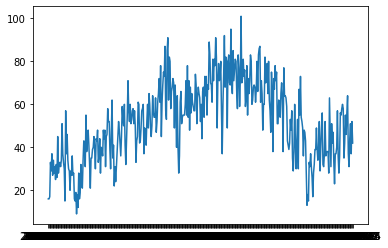

In [85]:
plt.plot(df_ma.iloc[:-3, 0])

## Re-Run model on cutoff data

In [70]:
opt_model = create_opt_model()

In [71]:
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train_cut, 
                  y_train_cut, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

Epoch 1/300
30/30 [==============================] - 3s 35ms/step - loss: 3089.7288 - mean_absolute_percentage_error: 94.7357 - val_loss: 3790.8901 - val_mean_absolute_percentage_error: 93.0133
Epoch 2/300
30/30 [==============================] - 0s 13ms/step - loss: 2776.0112 - mean_absolute_percentage_error: 87.8963 - val_loss: 3490.6895 - val_mean_absolute_percentage_error: 88.9137
Epoch 3/300
30/30 [==============================] - 0s 13ms/step - loss: 2563.3503 - mean_absolute_percentage_error: 83.3929 - val_loss: 3293.9939 - val_mean_absolute_percentage_error: 86.1259
Epoch 4/300
30/30 [==============================] - 0s 13ms/step - loss: 2430.1572 - mean_absolute_percentage_error: 80.4148 - val_loss: 3169.6423 - val_mean_absolute_percentage_error: 84.3177
Epoch 5/300
30/30 [==============================] - 0s 13ms/step - loss: 2339.3398 - mean_absolute_percentage_error: 78.4046 - val_loss: 3058.5256 - val_mean_absolute_percentage_error: 82.6702
Epoch 6/300
30/30 [===========

30/30 [==============================] - 0s 13ms/step - loss: 412.4799 - mean_absolute_percentage_error: 31.8615 - val_loss: 514.2993 - val_mean_absolute_percentage_error: 29.1110
Epoch 86/300
30/30 [==============================] - 0s 13ms/step - loss: 396.4577 - mean_absolute_percentage_error: 31.5514 - val_loss: 445.5037 - val_mean_absolute_percentage_error: 27.0105


In [72]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 162.8073 - mean_absolute_percentage_error: 31.0075


[162.8072967529297, 31.007532119750977]

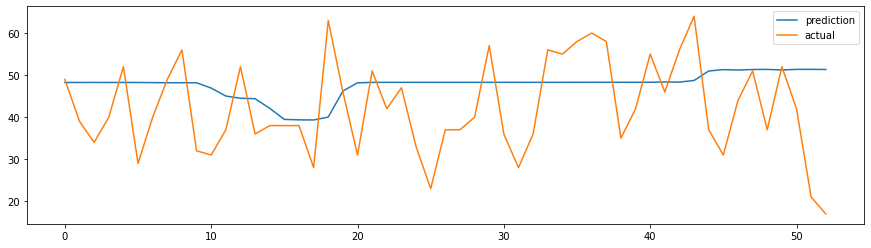

In [73]:
plt.figure(figsize= (15, 4))
plt.plot(opt_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();